In [2]:
# import module
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


# set directry
os.chdir('/Users/celerinoue/0_res/CTOS/')

# load

In [3]:
# load the data
def data_load():
    # [LOAD] ECv data
    file_1 = 'data/ECv_network_result_0.15.txt'
    data_ecv_ = pd.read_table(file_1, sep='\t', header=0)
    print(f'[LOAD]: {file_1}, input matrix: {data_ecv_.shape}')

    # [LOAD] tumor growth rate data (TGR data, drug1~7)
    file_2 = 'result/txt/IDEA1_1/tumor_growth_rate.pickle'
    with open(file_2, 'rb') as f:
        list_tgr_ = pickle.load(f)
        print(f'[LOAD]: {file_2}, list length: {len(list_tgr_)}')

    # [LOAD] drug name list
    file_3 = 'result/txt/drug_index.csv'
    data_drug_name = pd.read_csv(file_3, sep=',', header=0, index_col=0)
    print(f'[LOAD]: {file_3}, input matrix: {data_drug_name.shape}')

    return data_ecv_, list_tgr_, data_drug_name

data_ecv_, list_tgr_, data_drug_name = data_load()

[LOAD]: data/ECv_network_result_0.15.txt, input matrix: (78859, 52)
[LOAD]: result/txt/IDEA1_1/tumor_growth_rate.pickle, list length: 7
[LOAD]: result/txt/drug_index.csv, input matrix: (7, 2)


In [4]:
# reshape
def reshape(data_ecv_, list_tgr_):
    # reshape data_ecv
    data_ecv = data_ecv_.loc[:, ['Parent',
                                 'Child',
                                 'ECv:C97-float:8',  # CTOS_line = 1
                                 'ECv:C166-float:21',  # CTOS_line = 2
                                 'ECv:C86-float:17',  # CTOS_line = 3
                                 'ECv:C111-foat:18',  # CTOS_line = 4
                                 'ECv:C45-float:5',  # CTOS_line = 5
                                 'ECv:C48-float:6',  # CTOS_line = 6
                                 'ECv:C138-float:20',  # CTOS_line = 7
                                 'ECv:CB3-float:22',  # CTOS_line = 8
                                 'ECv:C75-float:7',  # CTOS_line = 9
                                 'ECv:C132-float:19'  # CTOS_line = 10
                                 ]]  # 必要なedgeを抽出

    # reshape list_tgr
    list_tgr_d28 = []
    for i in range(len(list_tgr_)):
        tgr_d28_ = list_tgr_[i].iloc[:, 8:]
        list_tgr_d28.append(tgr_d28_)

    print('[INFO] reshape the data')
    return data_ecv, list_tgr_d28


data_ecv, list_tgr_d28 = reshape(data_ecv_, list_tgr_)

[INFO] reshape the data


In [5]:
data_ecv

,Parent,Child,ECv:C97-float:8,ECv:C166-float:21,ECv:C86-float:17,ECv:C111-foat:18,ECv:C45-float:5,ECv:C48-float:6,ECv:C138-float:20,ECv:CB3-float:22,ECv:C75-float:7,ECv:C132-float:19
0,ITGA7,A23747,6.594815,6.345684,6.332206,6.537262,6.373183,6.657370,6.412025,6.539362,6.445698,6.374509
1,AXL,A23747,-0.047771,-0.039535,-0.015503,-0.028371,-0.032229,-0.068649,-0.015117,0.059047,-0.061376,-0.008655
2,AP1M2,A23747,-0.392876,0.091723,-0.200845,-0.231564,-0.265686,-0.224587,-0.127154,-0.075489,-0.166920,-0.368507
3,SLAMF1,A23747,0.129603,-0.259722,-0.175755,0.067454,-0.788439,-0.312984,-0.299465,-0.210768,-0.430493,0.224160
4,FBLN1,A23747,-0.178458,-0.196188,-0.124905,-0.170777,-0.081411,-0.161160,-0.134623,0.302383,-0.153786,-0.150178
...,...,...,...,...,...,...,...,...,...,...,...,...
78854,NACAP1,lincRNA:chrX:97546119-97657219_F,0.122925,-0.000558,-0.144826,-0.103876,0.001169,0.086230,-0.059603,0.053983,0.258925,-0.065045
78855,lincRNA:chr2:107293518-107358418_R,lincRNA:chrX:97546119-97657219_F,0.009782,0.054173,-0.227011,0.016717,-0.042315,0.107339,0.158652,0.257222,0.384503,0.093524
78856,A_24_P126691,lincRNA:chrX:97546119-97657219_R,12.492665,12.495724,12.495261,12.496654,12.493486,12.494454,12.497193,12.503603,12.505451,12.498717
78857,C1orf43,lincRNA:chrX:97546119-97657219_R,0.040848,0.031341,0.047562,0.029576,0.048071,-0.001850,0.039658,0.040479,0.053610,0.055074


# 相関係数の計算

In [6]:
# calculate correlation between [ECv & TGR]
def calculate_corr_ecv_tgr(data_ecv, data_drug_name, list_tgr_d28):
    list_corr_ = []
    for d, i in itertools.product(range(len(data_drug_name['drug_name'])), range(len(data_ecv))):
        # array TGR
        array_tgr = np.array(list_tgr_d28[d], dtype='float64').reshape(10,)  # drug 0~6 → 1
        # array gene
        array_ecv = np.array(data_ecv.iloc[i, 2:], dtype='float64')  # ecv 0~78858 → 1
        # corr
        corr = np.corrcoef(array_tgr, array_ecv)[0, 1]
        # append
        list_corr_.append(corr)
    #reshape
    list_corr = np.array(list_corr_).reshape(len(data_drug_name['drug_name']), -1)
    return list_corr
list_corr = calculate_corr_ecv_tgr(data_ecv, data_drug_name, list_tgr_d28)

In [7]:
list_corr.shape

(7, 78859)

In [8]:
# calculate range of ECv max-min value and save matrix
def cal_ecv_range(data_ecv, data_drug_name, list_corr):
    # calculate range of ECv max-min value
    list_ecv_range = []
    for i in range(len(data_ecv)):
        ecv_max = data_ecv.iloc[i, 2:].max() # LINE1~10の中でのECvの最大値
        ecv_min = data_ecv.iloc[i, 2:].min() # LINE1~10の中でのECvの最小値
        ecv_range = abs(ecv_max - ecv_min) # 絶対値(最大値 - 最小値)
        list_ecv_range.append(ecv_range)
    print(f'[INFO] make list of ECv max-min range [shape = {len(list_ecv_range)}]')

    # make matrix [1.parent, 2.child, 3.corr, 4.range_ecv]
    for d in range(len(data_drug_name)):
        matrix = data_ecv.iloc[:, :2] # 1,2列目
        matrix['CorrelationCoefficients'] = list_corr[d]
        matrix['range_ecv'] = list_ecv_range # 4列目
        # save
        savepath = f'result/txt/IDEA1_2/1_matrix_corr_and_range_ecv/CorrelationCoefficients_{data_drug_name["drug_name"][d]}.txt'
        matrix.to_csv(savepath, sep='\t', index=False)

    return list_ecv_range


list_ecv_range = cal_ecv_range(data_ecv, data_drug_name, list_corr)



[INFO] make list of ECv max-min range [shape = 78859]


# 相関係数のプロット

[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Control.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Cetuximab_20mg.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Cetuximab_60mg.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Oxaliplatin_3mg.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Oxaliplatin_10mg.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Irinotecan_3mg.png
[SAVE]: result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_Irinotecan_10mg.png


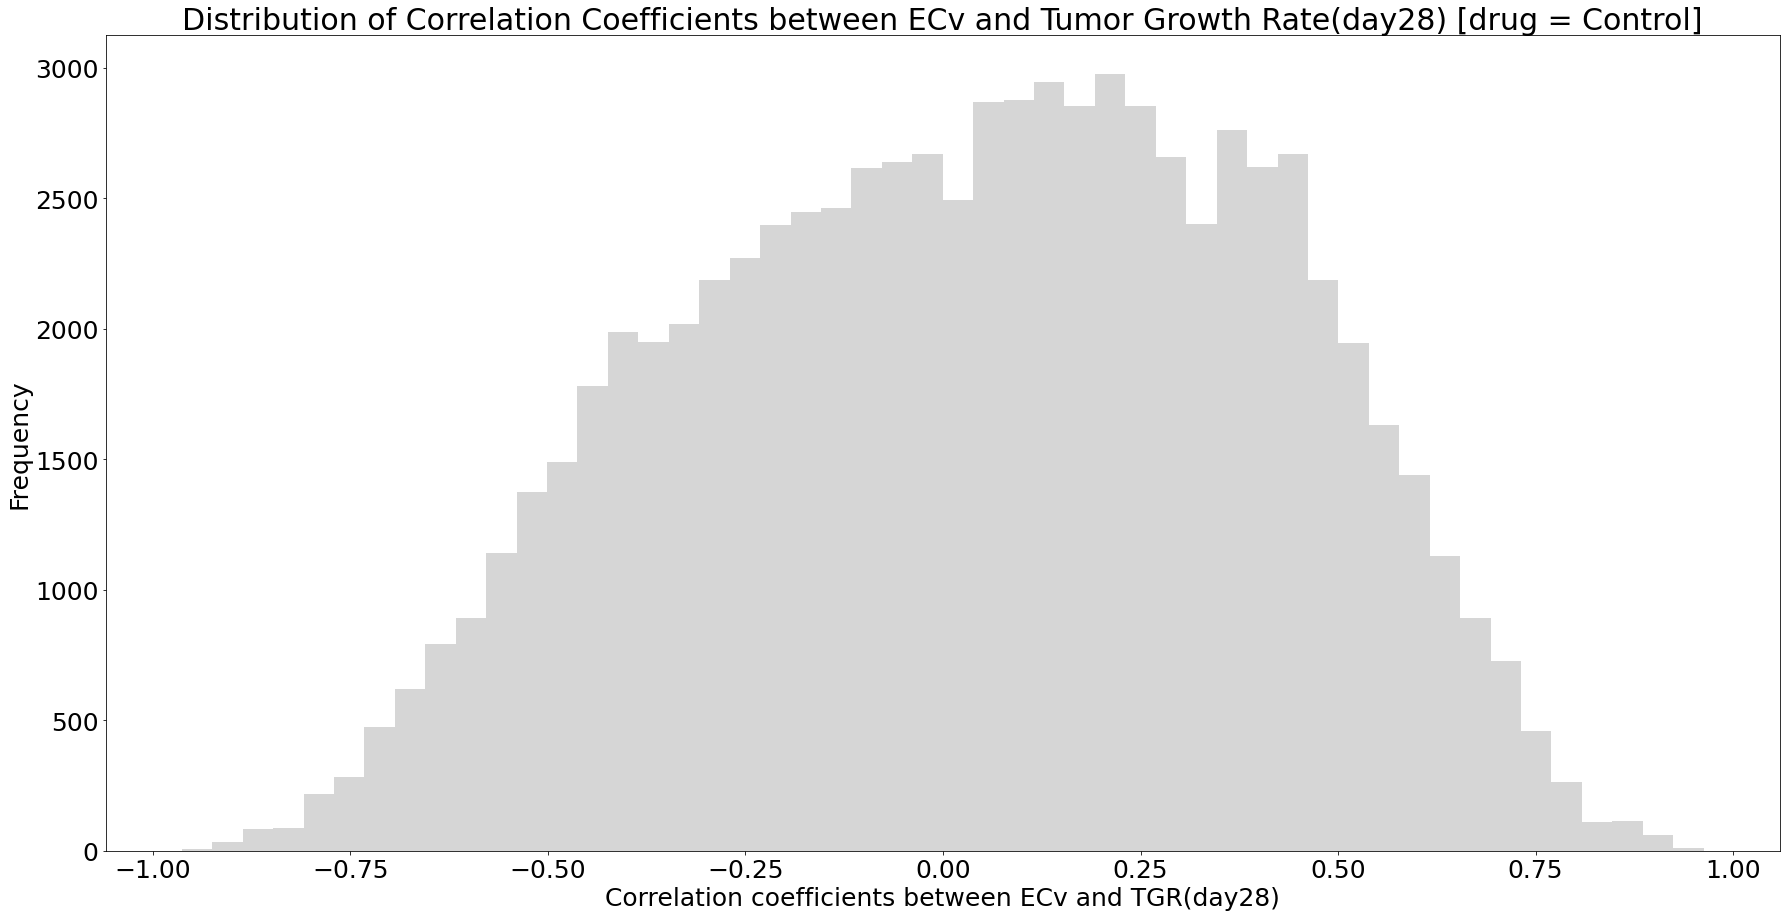

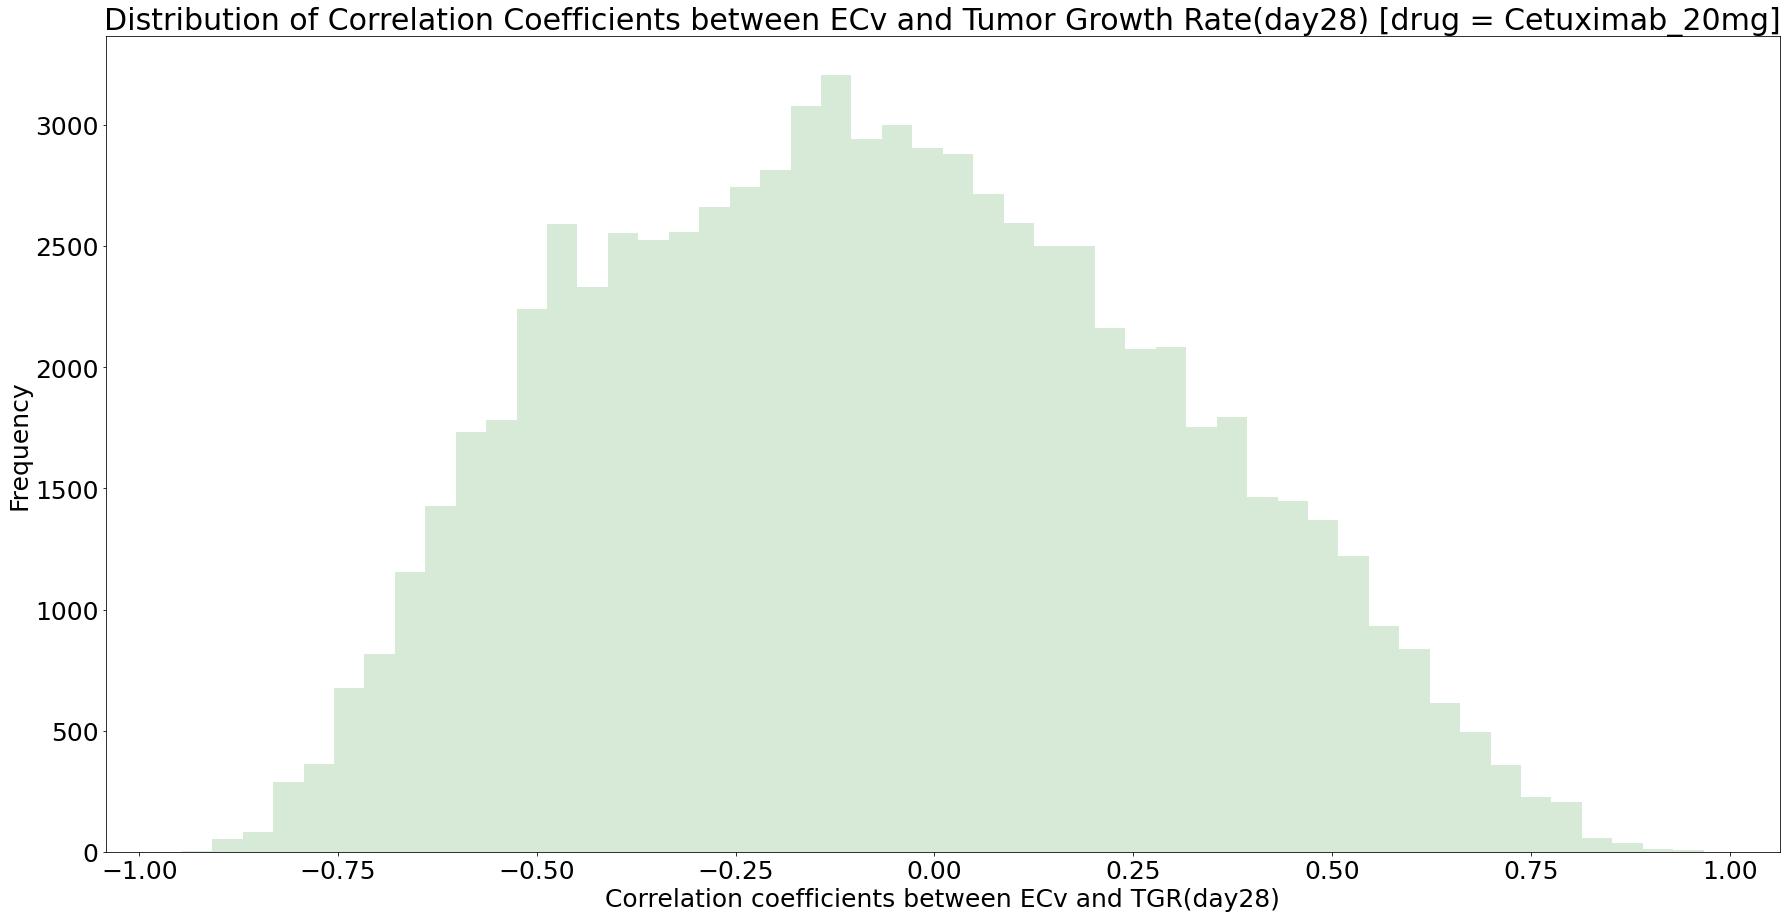

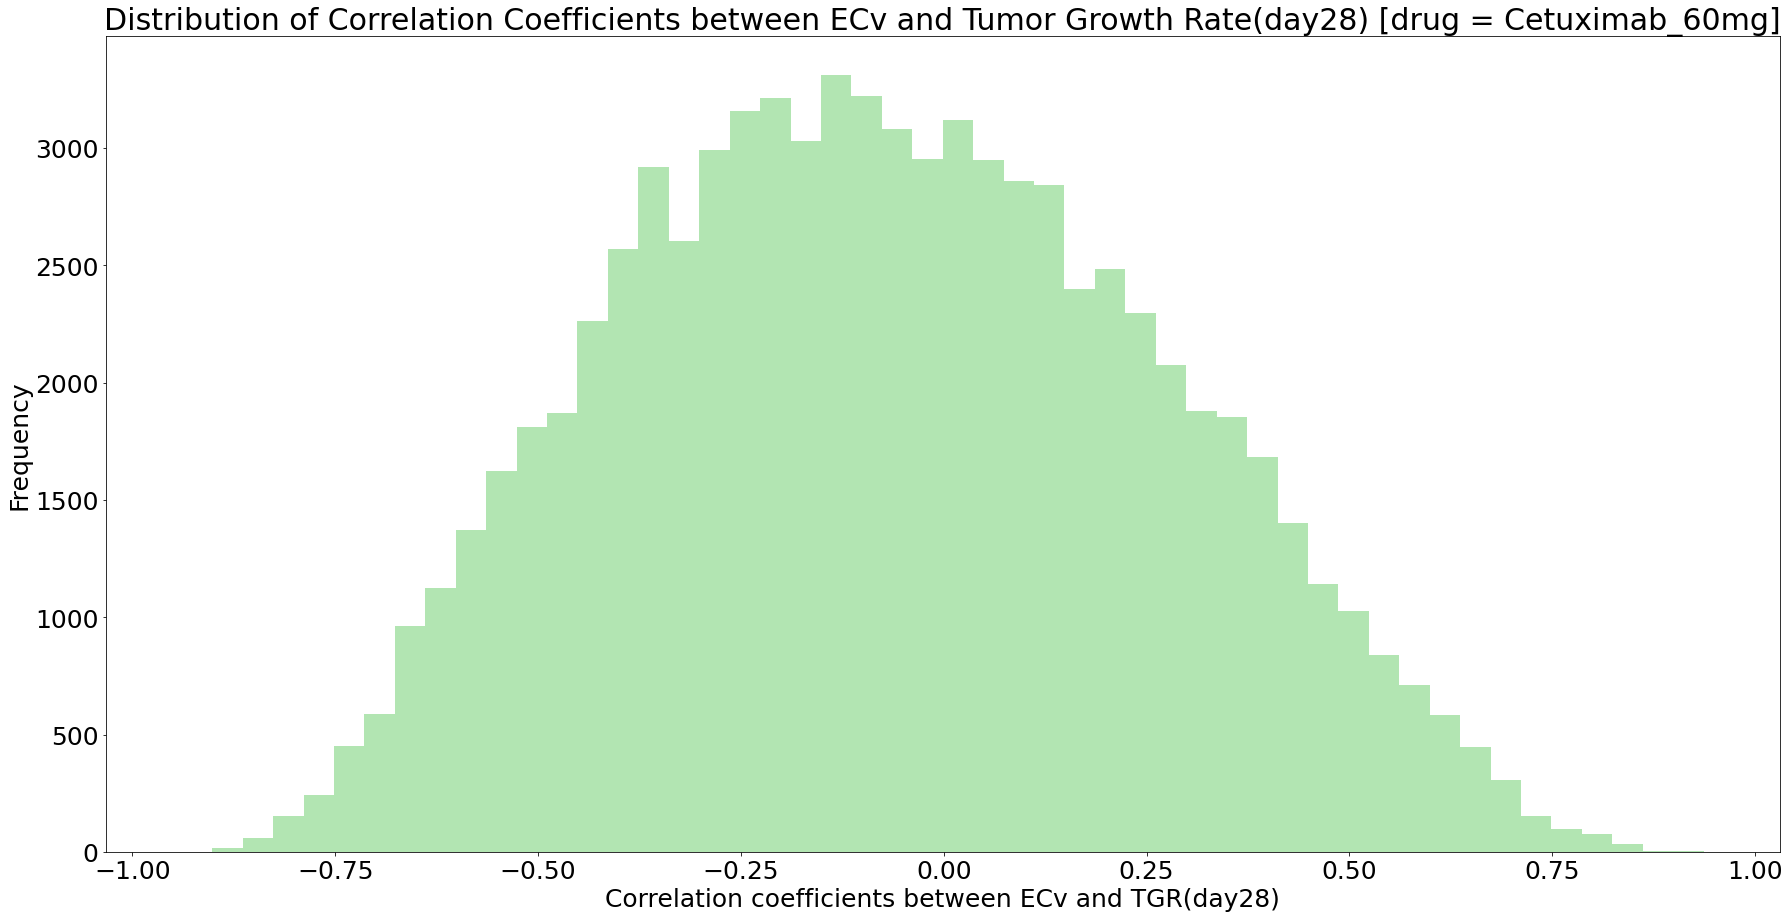

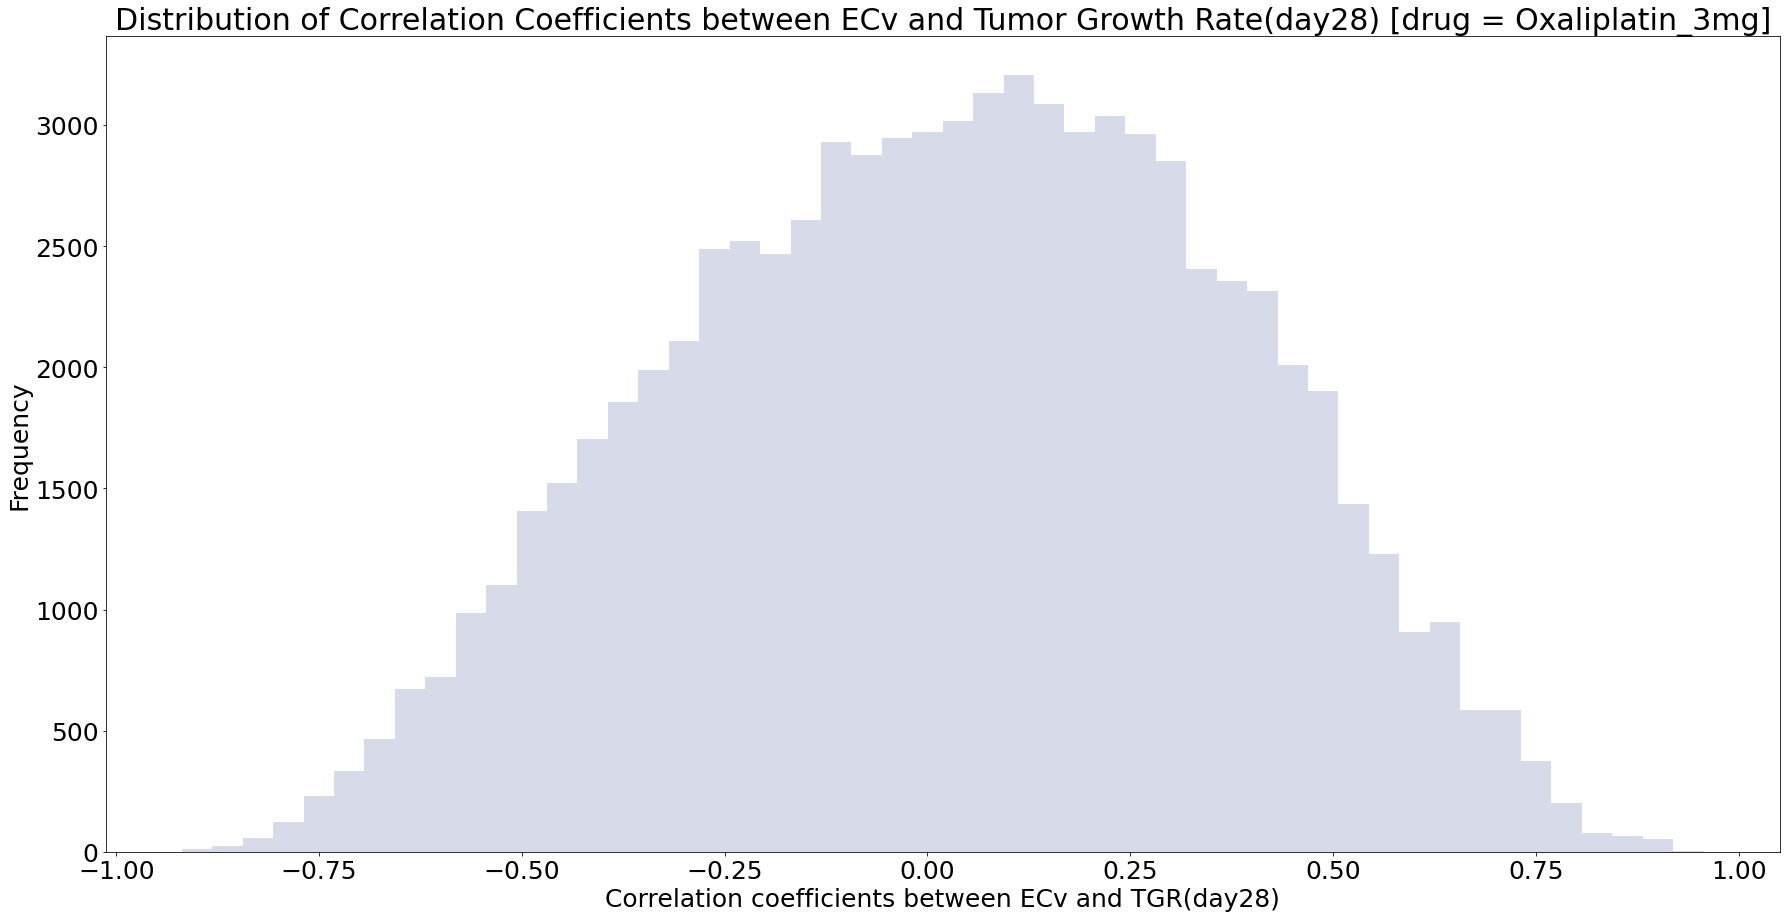

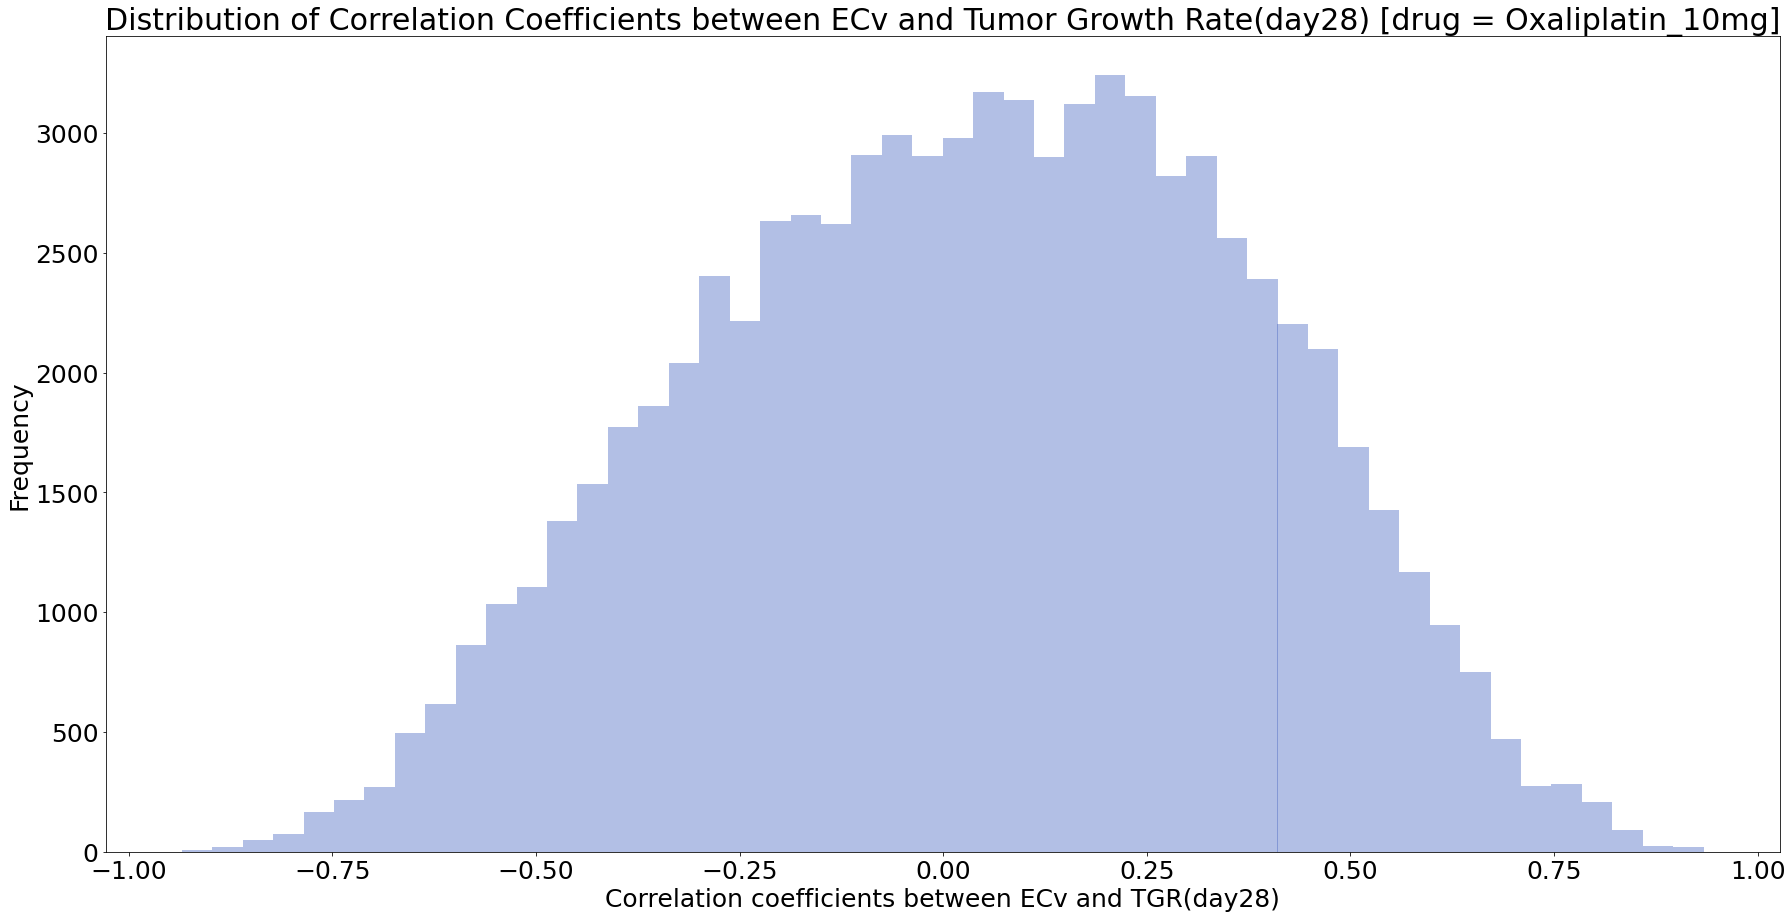

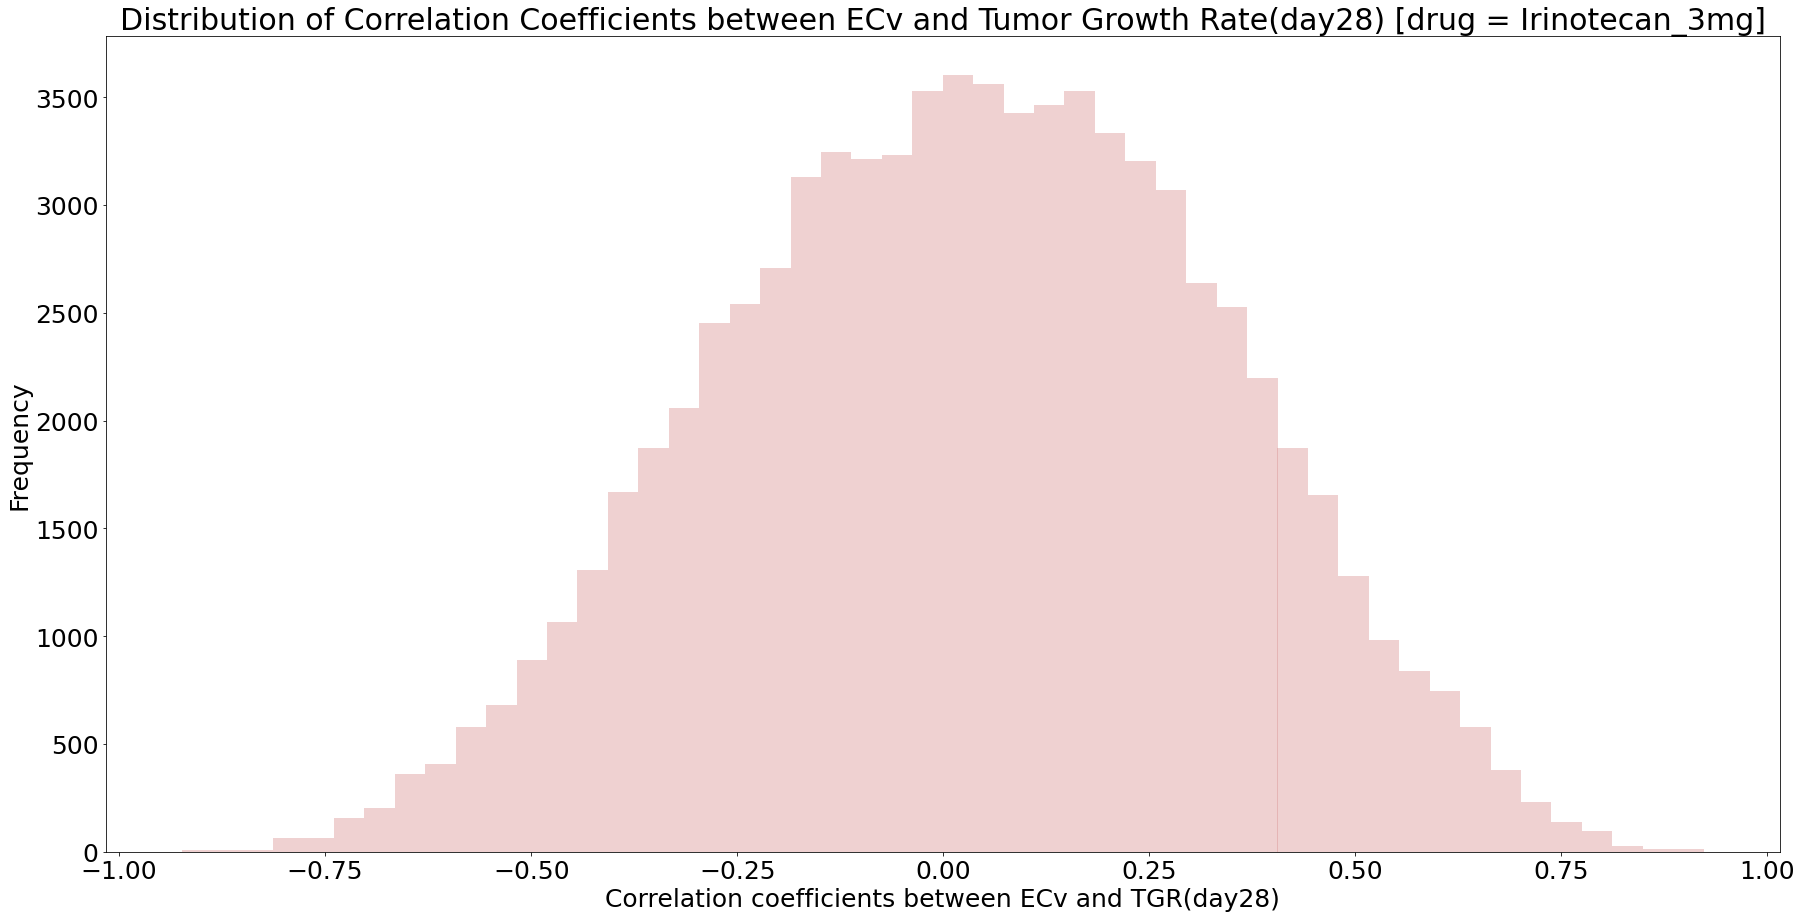

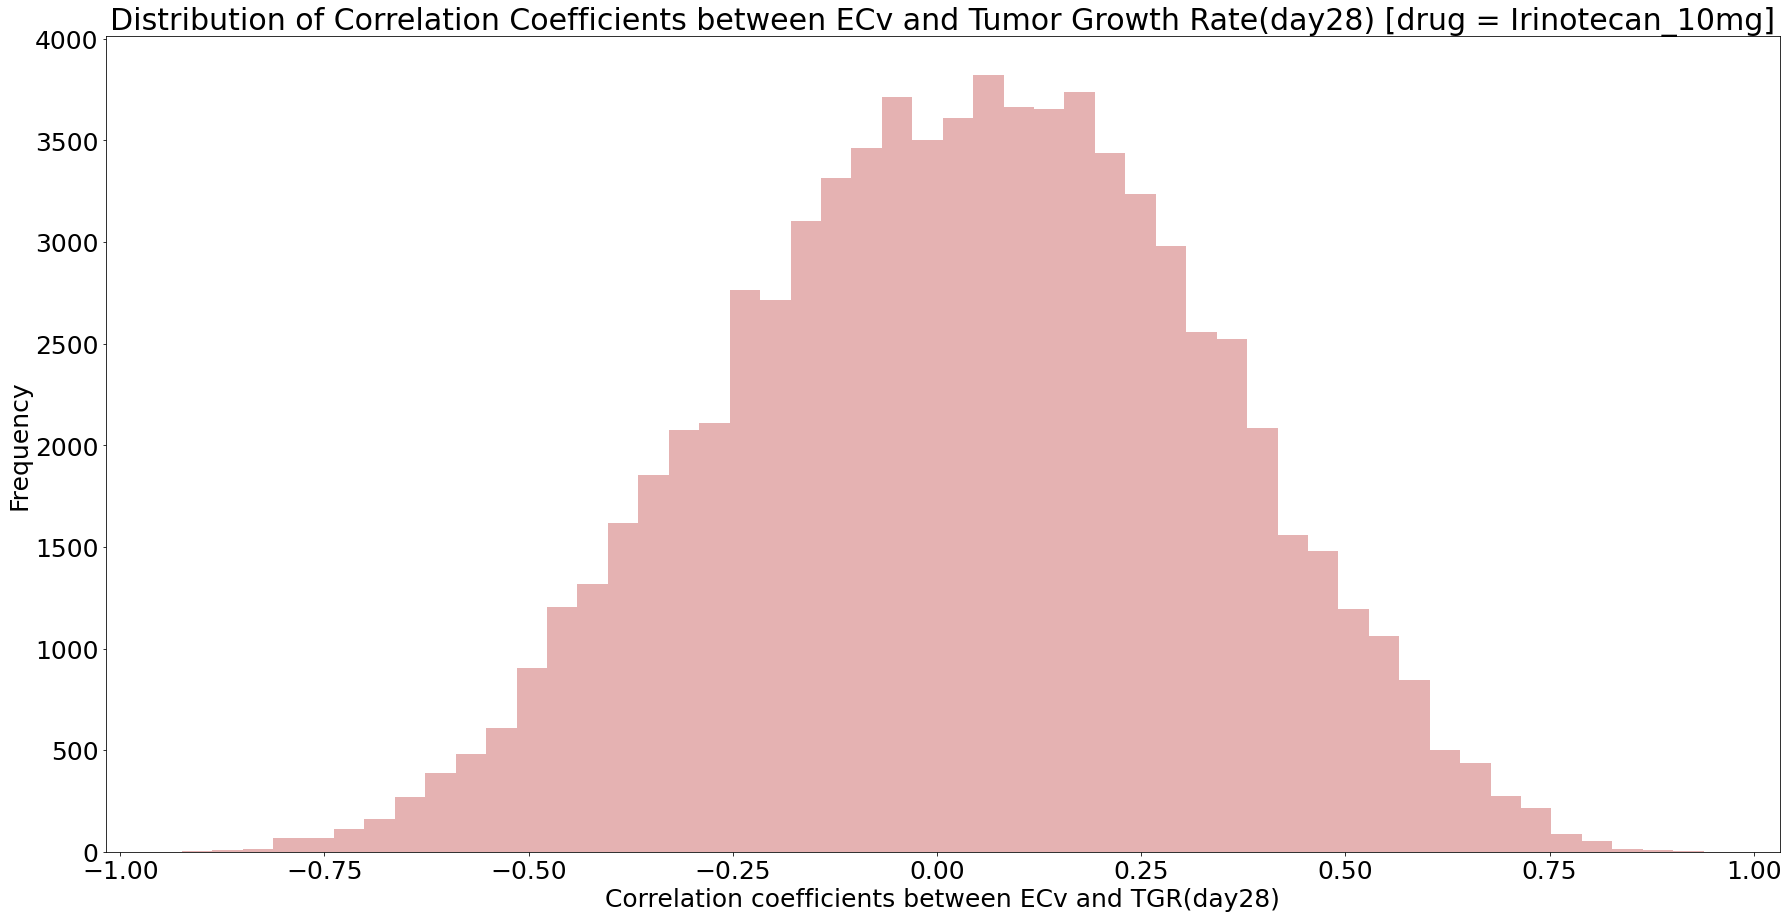

In [8]:
# plot distribution of correlation values[ECv & TGR]
def plot_distribution_corr_ecv_tgr(list_corr, data_drug_name):
    for l in range(len(list_corr)):
        # (Cetuximab, Oxaliplatin, Irinotecan) = (green, blue, red)
        colorlist = ["#999999", # gray
                     "#9BC99B", "#3FBF3F", # green
                     "#9BA7C9", "#3F5FBF", # blue
                     "#D88C8C", "#BF3F3F"  # red
                     ]
        # plot
        plt.figure(figsize=(30, 15))
        plt.rcParams["font.family"] = 'sans-serif'
        plt.rcParams['font.size'] = 25
        plt.title(
            f'Distribution of Correlation Coefficients between ECv and Tumor Growth Rate(day28) [drug = {data_drug_name["drug_name"][l]}]', fontsize=30)
        plt.xlabel(
            'Correlation coefficients between ECv and TGR(day28)', fontsize=25)
        plt.ylabel('Frequency', fontsize=25)
        sns.distplot(list_corr[l], color=colorlist[l], kde=False)
        # save
        savepath = f'result/fig/IDEA1_2/1_distribution_corr_ecv_TGR/fig_corrplot_{data_drug_name["drug_name"][l]}.png'
        plt.savefig(savepath, dpi=300, format='png', bbox_inches="tight")
        print(f'[SAVE]: {savepath}')
    return

plot_distribution_corr_ecv_tg(list_corr, data_drug_name)

drug = Control, index = 17030, parent = NAGS, child = DHDH
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Control.png
drug = Cetuximab_20mg, index = 45797, parent = SGK223, child = PPP2R2A
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Cetuximab_20mg.png
drug = Cetuximab_60mg, index = 38705, parent = CCDC125, child = MYADM
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Cetuximab_60mg.png
drug = Oxaliplatin_3mg, index = 17736, parent = MYH9, child = DOCK1
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Oxaliplatin_3mg.png
drug = Oxaliplatin_10mg, index = 20843, parent = ALG12, child = ERLIN1
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Oxaliplatin_10mg.png
drug = Irinotecan_3mg, index = 23540, parent = ASAH2, child = FOS
[SAVE]: result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_Irinotecan_3mg.png
drug = Irinotecan_10mg, index = 30668, parent = CTBS, child = KIAA1530
[SAVE]: result/fig/IDEA1

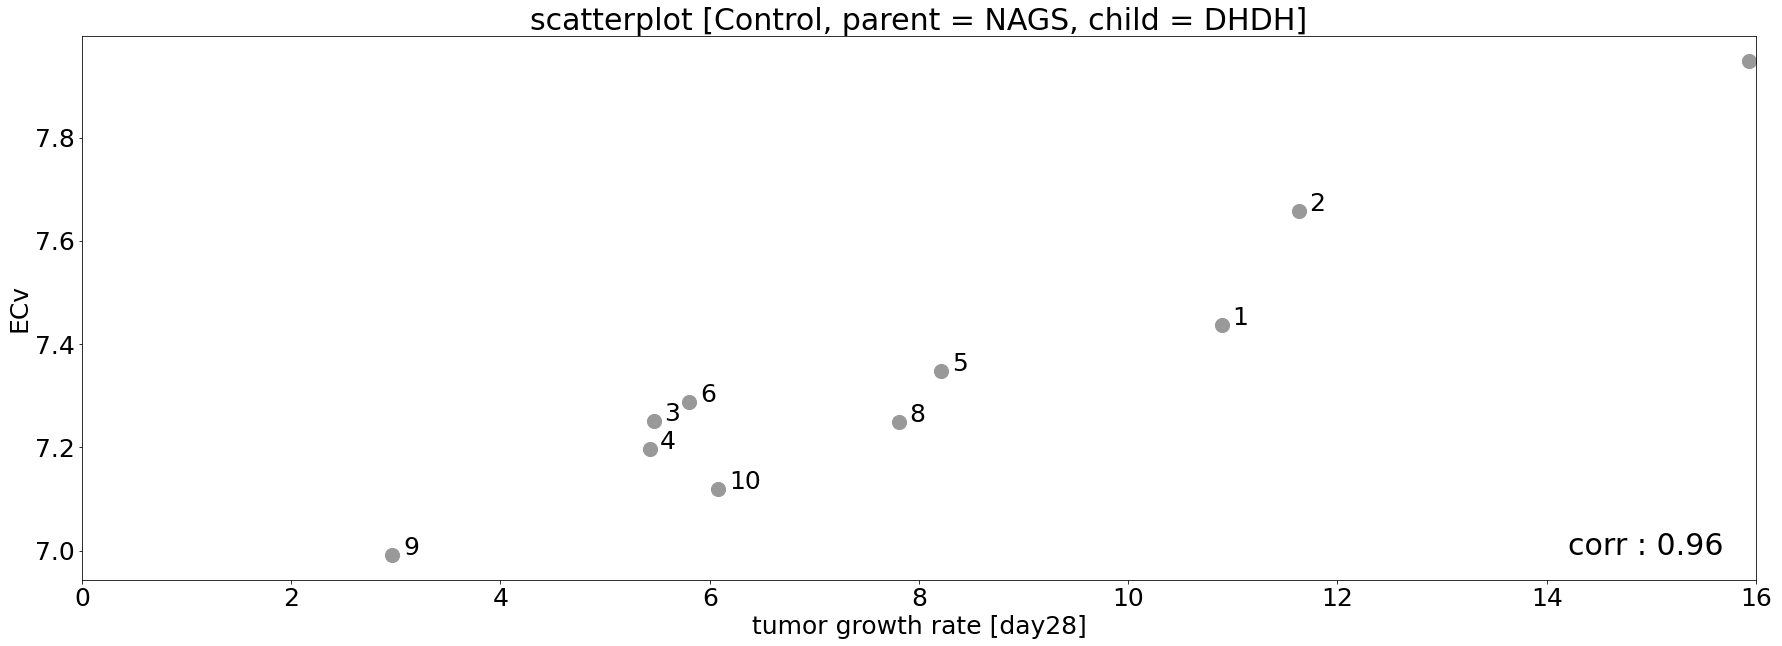

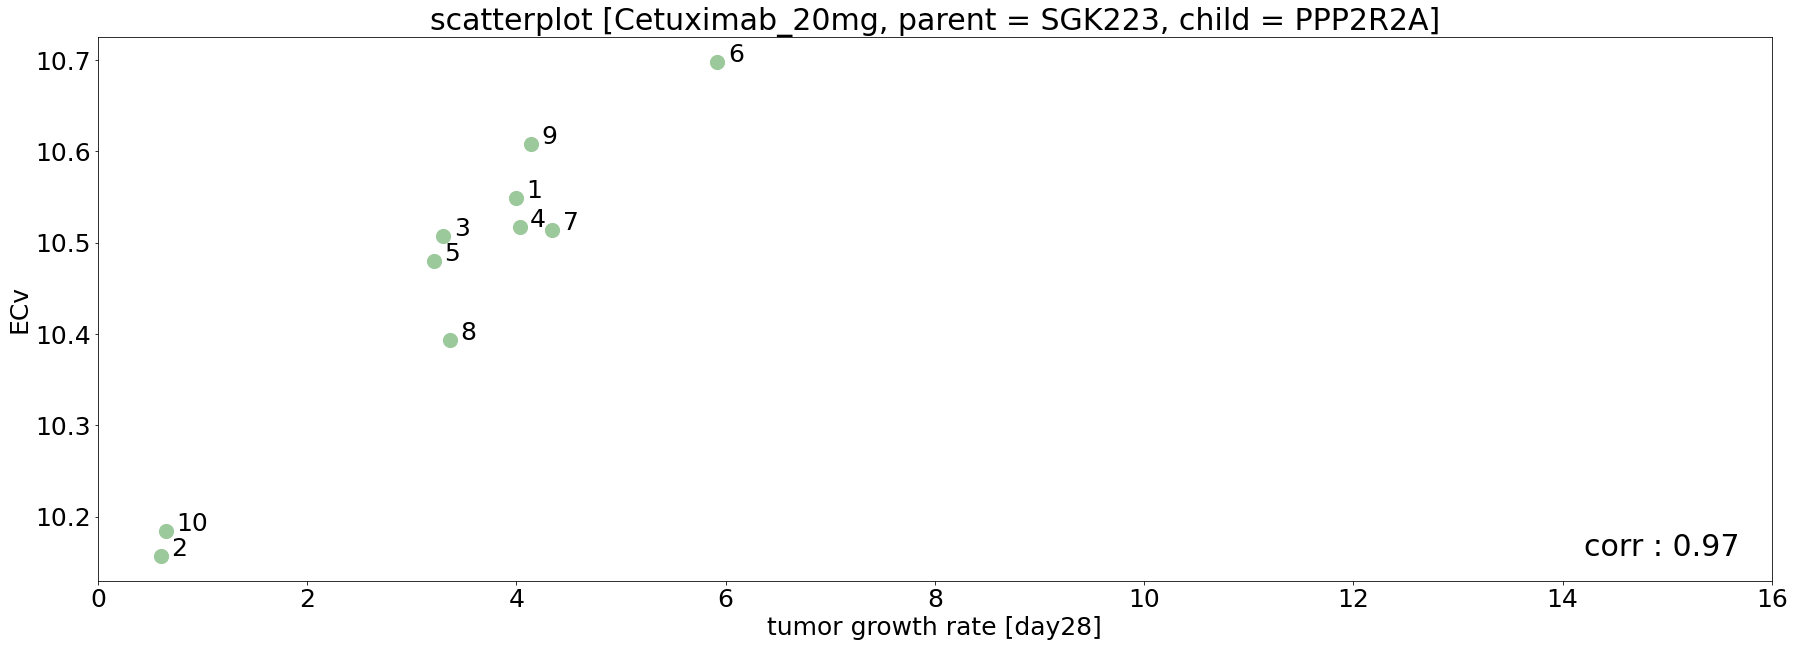

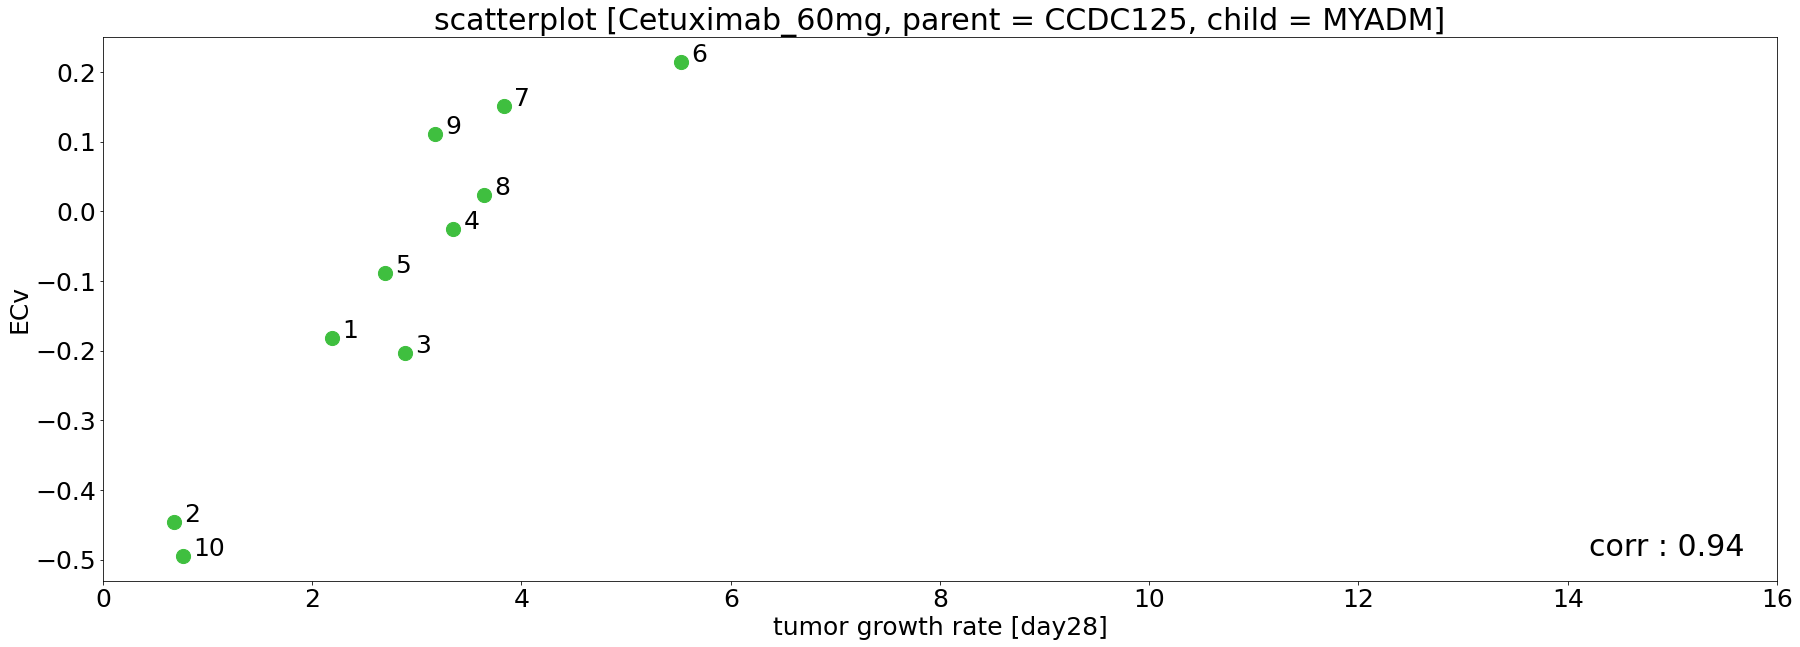

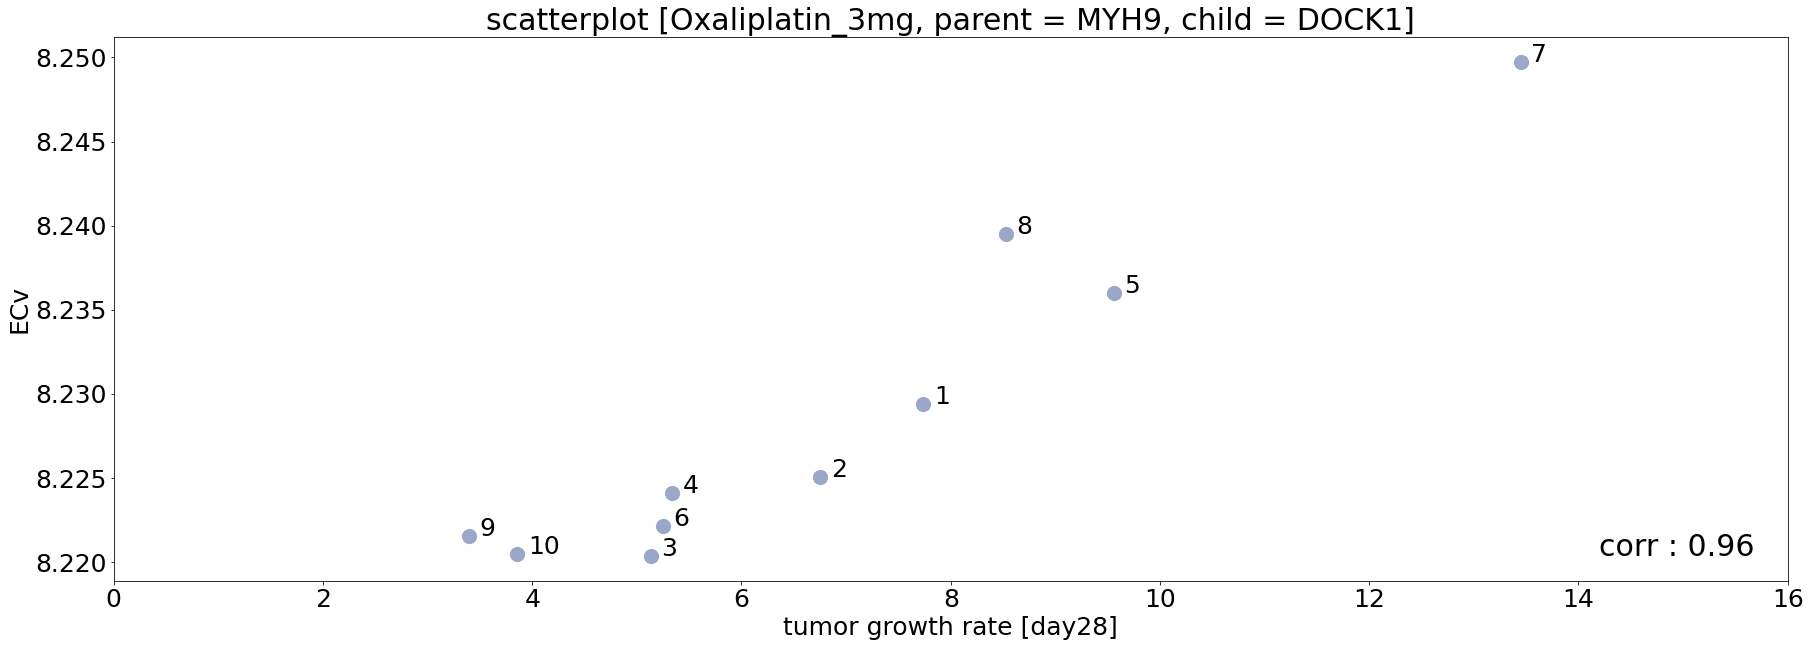

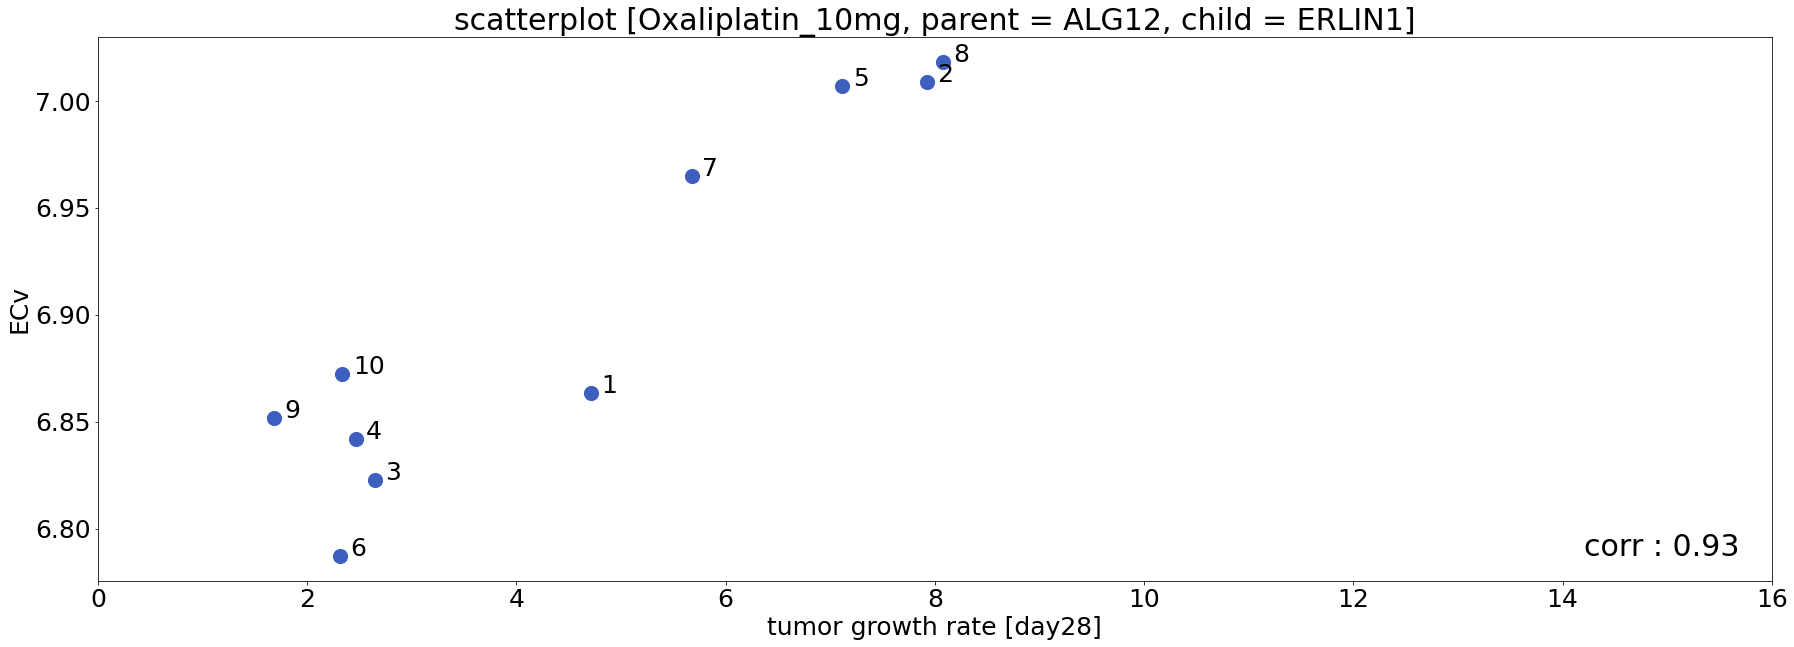

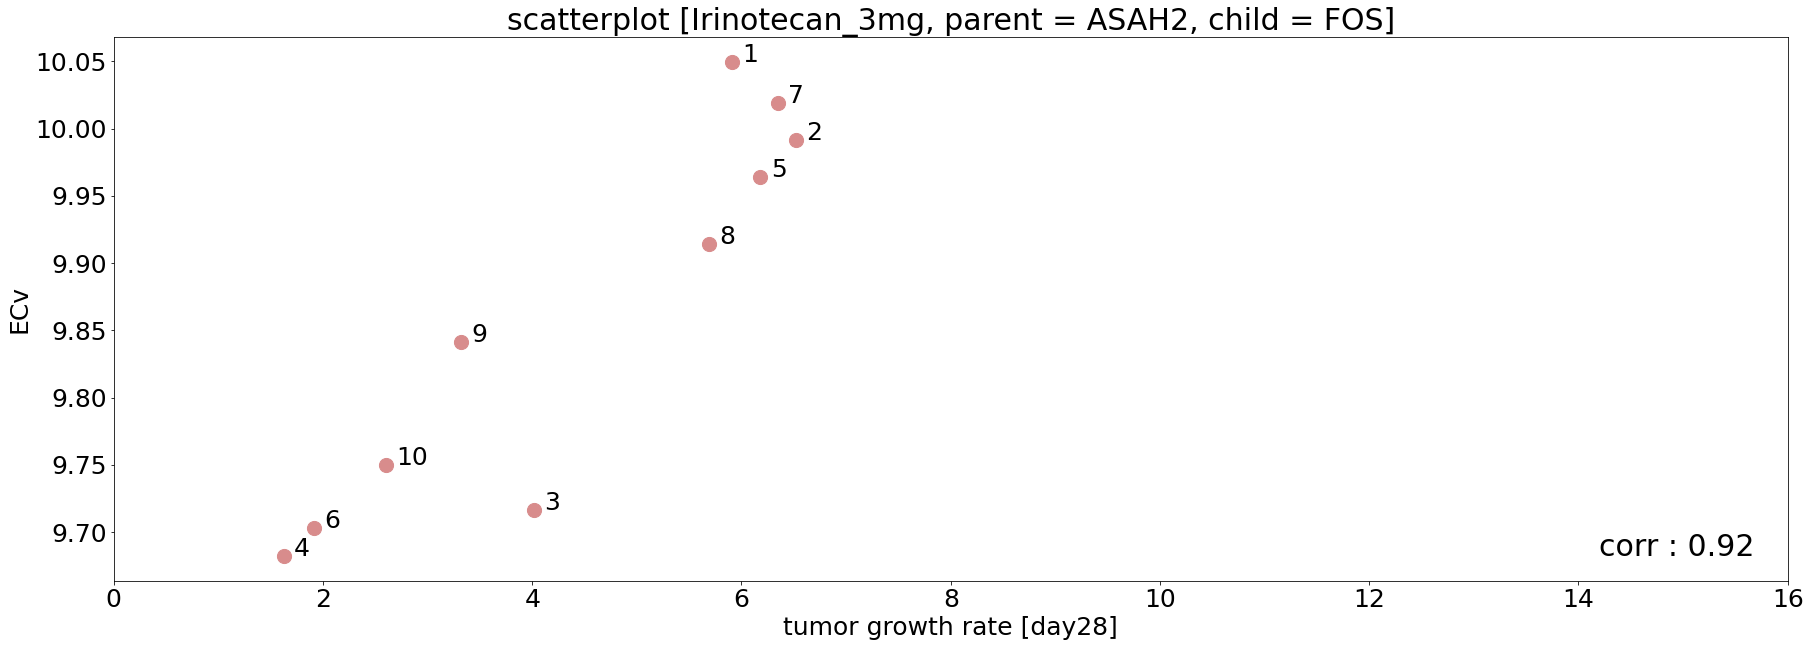

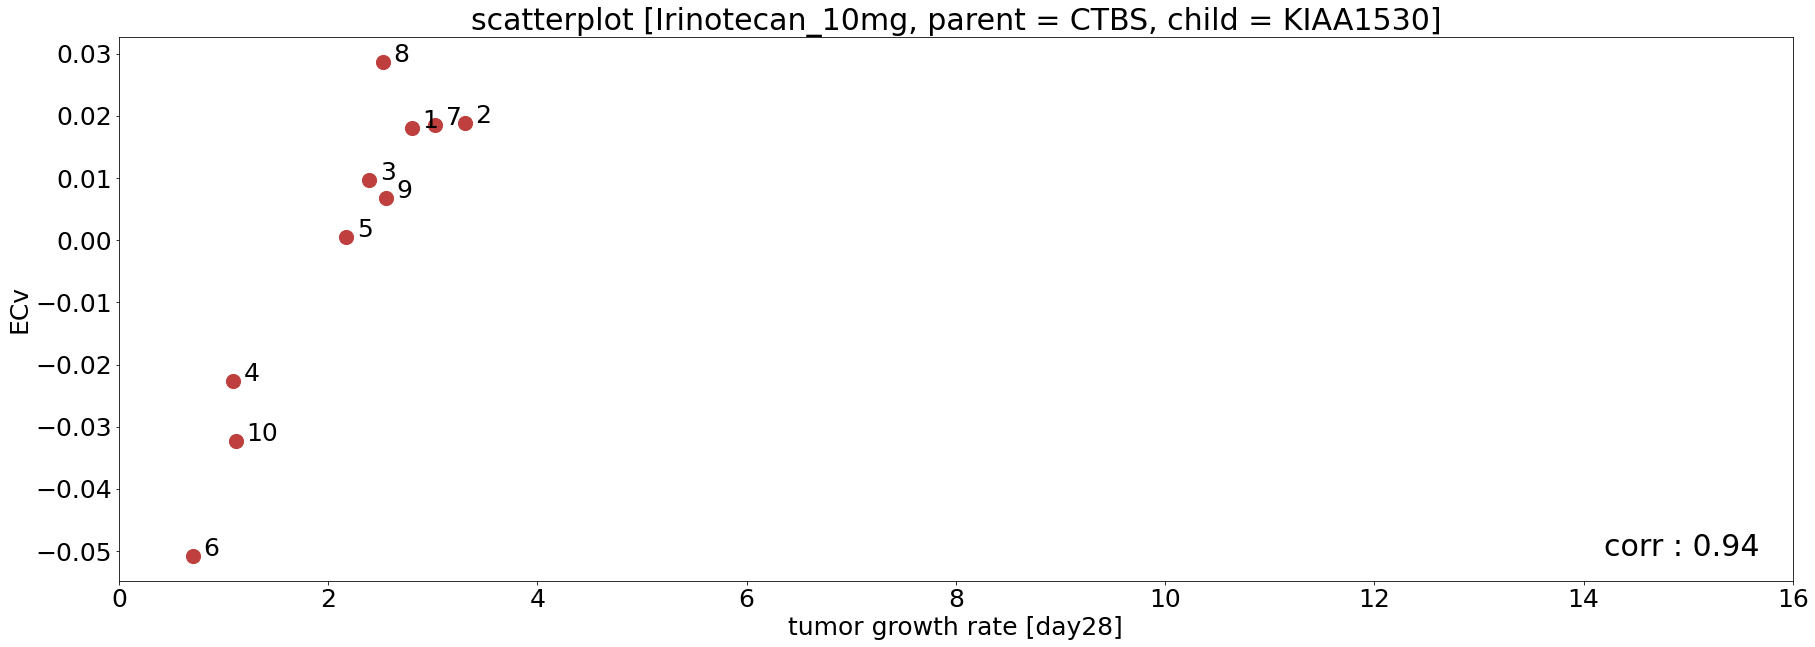

In [9]:
# Plot a scatter plot of pairs with the largest correlation coefficient
def plot_scatter_maxcorr(data_ecv, data_drug_name, list_corr):
    # 各薬剤ごとに
    for d in range(len(data_drug_name)):
        # 相関係数最大のecvのindexと値, parent, childの名前を取得=========
        maxcorr_index = list(list_corr[d]).index(max(list_corr[d])) # indexを取得
        drug = data_drug_name["drug_name"][d]
        parent = data_ecv.iloc[maxcorr_index, :2][0] # parentの名前を取得
        child = data_ecv.iloc[maxcorr_index, :2][1] # childの名前を取得
        tgr_value = np.array(list_tgr_d28[d], dtype='float64').reshape(10,) # CTOS1~10のtgrの値
        ecv_value = np.array(data_ecv.iloc[maxcorr_index, 2:], dtype='float64') # CTOS1~10のecvの値
        print(f'drug = {drug}, index = {maxcorr_index}, parent = {parent}, child = {child}')

        # scatter plot==================
        plt.figure(figsize=(30, 10))
        plt.rcParams["font.family"] = 'sans-serif'
        plt.rcParams['font.size'] = 25
        plt.title(
            f'scatterplot [{drug}, parent = {parent}, child = {child}]', fontsize=30)
        plt.xlim([0, 16])
        #plt.ylim([0,16])
        plt.xlabel('tumor growth rate [day28]', fontsize=25)
        plt.ylabel('ECv', fontsize=25)
        plt.text(14.2, min(ecv_value),
                 f"corr : {round(max(list_corr[d]), 2)}", size=30)

        CTOS_LINE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

        # (Cetuximab, Oxaliplatin, Irinotecan) = (green, blue, red)
        colorlist = ["#999999", # gray
                     "#9BC99B", "#3FBF3F", # green
                     "#9BA7C9", "#3F5FBF", # blue
                     "#D88C8C", "#BF3F3F"  # red
                     ]

        for (x, y, k) in zip(tgr_value, ecv_value, CTOS_LINE):
            plt.scatter(x, y, color=colorlist[d], s=200)
            plt.annotate(k, xy=(x+0.1, y), size=25)

        # save figure===============
        savepath = f'result/fig/IDEA1_2/2_scatterplot_corrmax/fig_scatterplot_{data_drug_name["drug_name"][d]}.png'
        plt.savefig(savepath, dpi=300, format='png', bbox_inches="tight")
        print(f'[SAVE]: {savepath}')
    return

plot_scatter_maxcorr(data_ecv, data_drug_name, list_corr)

[SAVE]: result/fig/IDEA1_2/3_distribution_range_ecv_TGR/fig_scatterplot_range_ecv.png


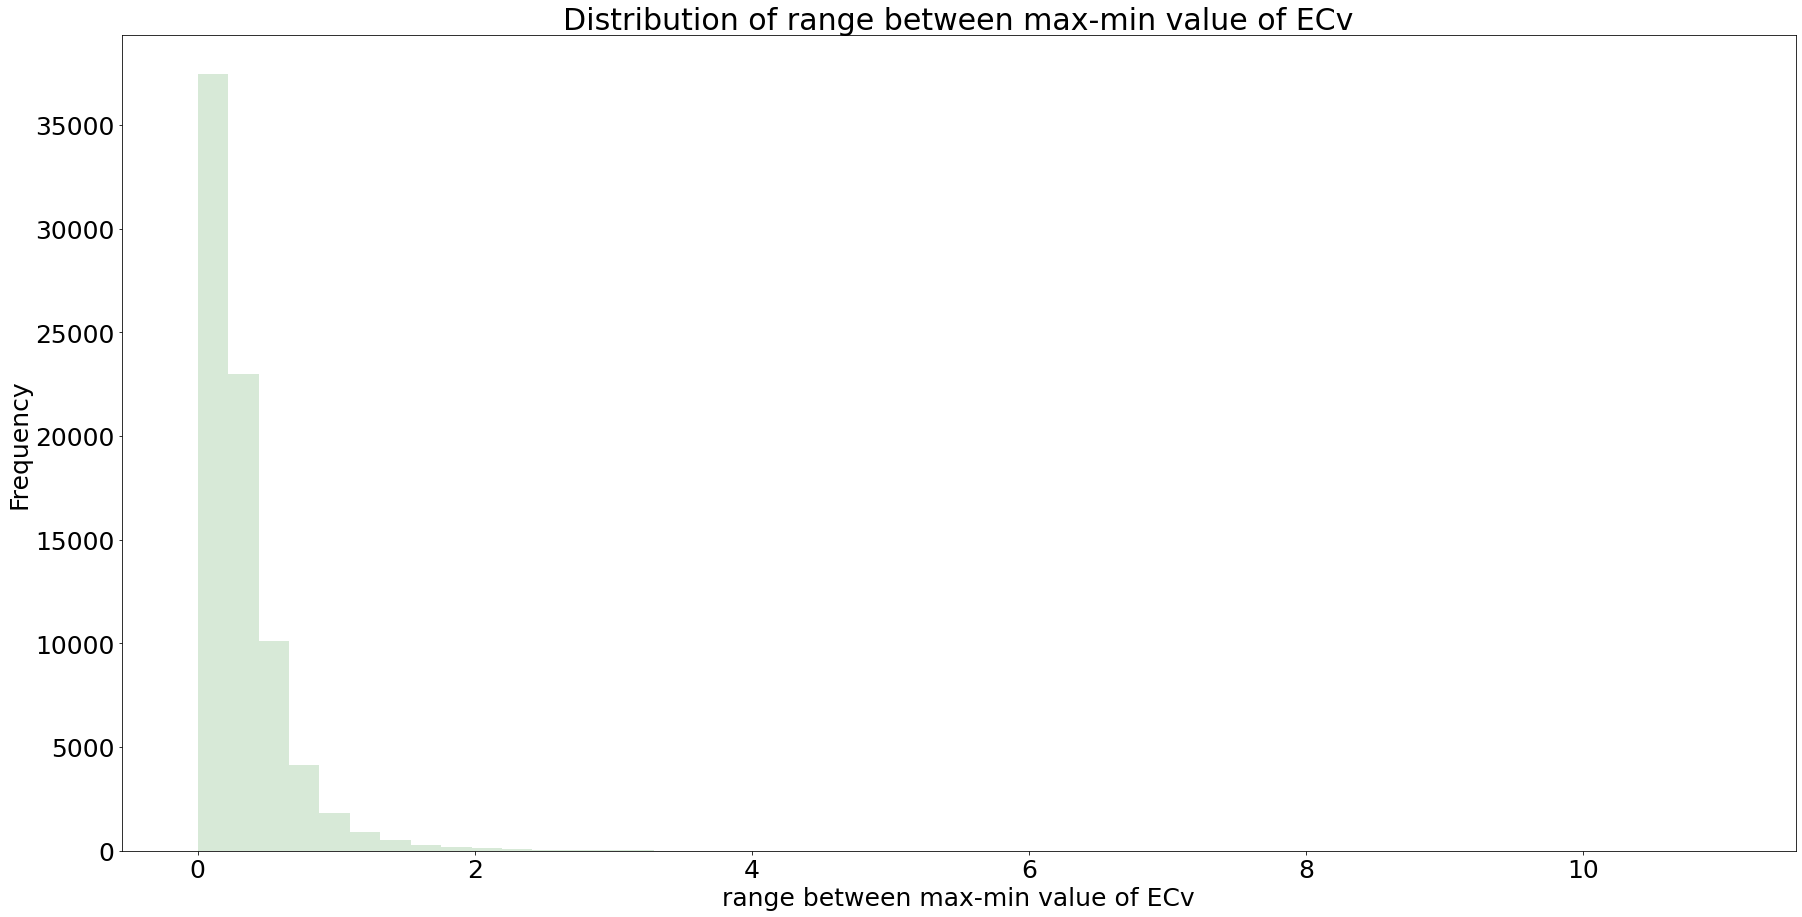

In [9]:
# plot distribution of range [ECv & TGR]
def plot_distribution_ecv_range(list_ecv_range):
    # figure
    plt.figure(figsize=(30, 15))
    plt.rcParams["font.family"] = 'sans-serif'
    plt.rcParams['font.size'] = 25
    plt.title(f'Distribution of range between max-min value of ECv', fontsize=30)
    plt.xlabel('range between max-min value of ECv', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    sns.distplot(list_ecv_range, color="#9BC99B", kde=False)
    # save
    savepath = f'result/fig/IDEA1_2/3_distribution_range_ecv_TGR/fig_scatterplot_range_ecv.png'
    plt.savefig(savepath, dpi=300, format='png', bbox_inches="tight")
    print(f'[SAVE]: {savepath}')
    return

plot_distribution_ecv_range(list_ecv_range)